# BosonicStuff.jl

This is a collection of most of the code used in the following papers:

[1] O. Mansikkamäki, S. Laine, and M. Silveri, [Phases of the disordered Bose-Hubbard model with attractive interactions](https://link.aps.org/doi/10.1103/PhysRevB.103.L220202), Phys. Rev. B 103, L220202 (2021).

[2] O. Mansikkamäki et al., [Beyond Hard-Core Bosons in Transmon Arrays](https://link.aps.org/doi/10.1103/PRXQuantum.3.040314), PRX Quantum 3, 040314 (2022).

[3] O. Busel et al., [Dissipation and Dephasing of Interacting Photons in Transmon Arrays](http://arxiv.org/abs/2301.07025), arXiv:2301.07025

In this notebook, we will first take a brief look at the basic usage of the `BosonicStuff.jl` package, followed by examples on the reproduction of some of the results of the above papers. 

The `BosonicStuff` module includes five files:  
    `Basis.jl` contains functions for handling bases,  
    `Operators.jl` contains functions for generating matrix representation of operators,  
    `Trajectories.jl` contains functions for running quantum trajectories,  
    `Miscellaneous_quantuties.jl` contains functions for computing e.g., inverse participation ratios, and  
    `Transform.jl` contains a function for generating matrix representations of the transformation to the reciprocal space.
    
    
Note that the package was rather speedily gathered together and might therefore have some bugs in it. When connected to the University of Oulu intranet, the package is available at `https://version.oulu.fi/nanomo_quantum/bosonicstuff.jl.git`. Like any Julia package, it can be loaded as follows:

In [1]:
# When connected to the intranet, the line
# ]add https://version.oulu.fi/nanomo_quantum/bosonicstuff.jl.git
# clones the package to the local machine. It can then be loaded as
using BosonicStuff

## Basis.jl

This file contains the definitions for objects of the abstract type `Basis`. There are currently three concrete subtypes of `Basis`:  
`Basis_constant_N` for a basis with a constant number of bosons `N`,  
`Basis_global_max_N` for a basis where the maximum number of bosons in a basis state is `N`, and  
`Basis_local_max_N` for a basis where the maximum number of bosons in each site of a basis state is `N`.

Each of these subtypes contains only the lenght of the chain `L` (number of sites in an array) and the number of bosons `N`, the exact meaning of which depends on the subtype. See the below cell for an example of usage.


In [2]:
function basis_test(L, N)
    # a basis is generated simply as
    basis = Basis_constant_N(L, N)
    
    # one can get the dimension of the basis with
    println("the dimension is ", length(basis), "\n") # or equivalently with dimension(basis)
    
    i = rand(1:length(basis))
    # the ith basis vector is given by
    println("the ith basis vector is ", basis[i], ", i = ", i, "\n")
    
    fock = [0, 1, 0, 1]
    # the index of a given basis state is given by
    println("the index of the state ", fock, " is ", find_index(basis, fock), "\n")
    
    # the basis objects are also iterable
    println(basis, " contains the following basis vectors:" )
    for fock in basis
        println(fock)
    end
    
end

basis_test(4, 2)

the dimension is 10

the ith basis vector is [0, 1, 1, 0], i = 6

the index of the state [0, 1, 0, 1] is 7

Basis_constant_N(4, 2) contains the following basis vectors:
[2, 0, 0, 0]
[1, 1, 0, 0]
[1, 0, 1, 0]
[1, 0, 0, 1]
[0, 2, 0, 0]
[0, 1, 1, 0]
[0, 1, 0, 1]
[0, 0, 2, 0]
[0, 0, 1, 1]
[0, 0, 0, 2]


`Basis.jl` also contains functions for initialising product states in the bases and printing state vectors:

In [3]:
using LinearAlgebra

function state_test()
    basis = Basis_constant_N(4, 2)
    fock = [0, 1, 0, 1]
    
    state = product_state(basis, fock) # state[find_index(basis, fock)] = 1.
    state += product_state(basis, (2, 3))
    normalize!(state) # from LinearAlgebra
    
    print_state(basis, state)
end

state_test()


0.7071 + 0.0im |0101⟩         0.5
0.7071 + 0.0im |0020⟩         1.0



In [4]:
?product_state

search: product_state



`product_state(basis::Basis, fock::Vector{Int64})`

`product_state(basis::Basis, fock::Tuple{Int64, Int64})`

`product_state(basis::Basis, fock::Vector{Tuple{Int64, Int64}})`

Return the product state `fock` represented in the basis `basis`.

E.g. the calls `product_state(basis, [0, 3, 0, 0])` and `product_state(basis, (3, 2))` return the same vector.

Similarly, `product_state(basis, [0, 3, 0, 2, 0])` and `product_state(basis, [(3, 2), (2, 4)])` result in the same vector.


## Operators.jl

This file contains a function for generating matrix representations of operators. For example, the below generates a reflection symmetry operator: 

In [5]:
function test_operator()
    basis = Basis_constant_N(4, 2)
    op = operator(basis, x -> (reverse(x), 1)) # reflection symmetry
    
    state = product_state(basis, [1, 0, 1, 0])
    println("state before:")
    print_state(basis, state)
    
    println("state after:")
    state = op * state
    print_state(basis, state)
end

test_operator()

state before:
1.0 + 0.0im |1010⟩         1.0

state after:
1.0 + 0.0im |0101⟩         1.0



For more details on how to generate operators, see the documentation:

In [6]:
?operator

search: operator test_operator diagonal_operator



`operator(basis::Basis, action::Function; element_type = Float64, add_adjoint = false)`

Construct a sparse matrix representation (`SparseMatrixCSC{element_type, Int64}`) of an operator whose action on the basis vectors `basis[i]` is defined by the function `action(fock)`. The function `action` should take as its argument a basis vector and return one or more basis vectors and corresponding matrix elements:

`fock, element = action(basis[i])`,

where `typeof(fock)` is `Vector{Int64}` or `Vector{Vector{Int64}}` and `typeof(element)` is `element_type` or `Vector{element_type}`.

Note that the function assumes that the output of `action` actually belongs to `basis`. If it does not, the function either breaks or works incorrectly.


The file also contains some pre-written function for generating operators, such as the bosonic number operators (see ?number and ?numbers) and the attractive Bose-Hubbard Hamiltonian: 

In [7]:
?ABH_Hamiltonian

search: ABH_Hamiltonian



`ABH_Hamiltonian(basis::Basis; periodic = false, split = true, J = 1, U = 1, dims = (0, 0))`

Construct a sparse matrix representation of the attractive Bose-Hubbard Hamiltonian $\hat{H} = -\frac{U}{2}\sum_\ell \hat{n} (\hat{n}_\ell - 1) + J \sum_\ell (\hat{a}^\dagger_\ell \hat{a}_{\ell + 1} + \text{H.c.}).$

The interaction and hopping terms are returned separately by default (`split = true`).

For a rectangular 2D array, set `dims = (L1, L2)`, where `L1` and `L2` are the lengths of the edges. Set `periodic` to 1 for a periodic array in one direction, and 2 for both directions.


# Examples
The rest of the package (`Trajectories.jl`, `Miscellaneous_quantities.jl`, and `Transform.jl`) is presented via examples reproducing some of the results of the papers listed at the top of this notebook. In the examples, we will be using the `Plots.jl` package for plotting the results and `LaTeXStrings.jl` for making the plot labels prettier. 

## Example 1: Ground state phase diagram [[1]](https://link.aps.org/doi/10.1103/PhysRevB.103.L220202)
In the paper, the ground state phase diagram was made for a chain of length $L = 8$ with $N = 4$ bosons and averaged over 1000 realisations. In the below code, for a bit speedier calculation, I've set $L = 6$ and the number of realisations to 100. The ground states are computed with the `KrylovKit.jl` package, and the inverse participation  ratios are made into a plottable image with the `Images.jl` package. The computation process is parallelised if the kernel has been set up to use multiple threads.

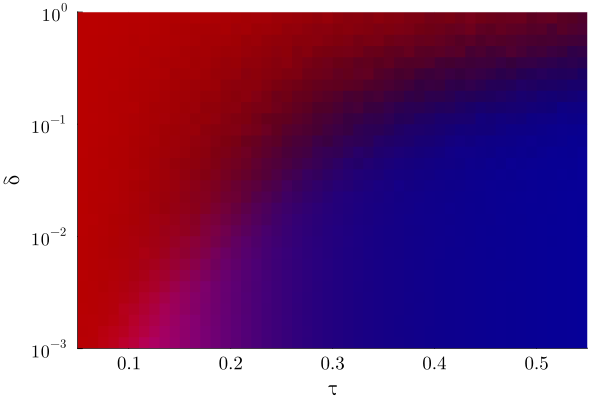

 47.805360 seconds (472.20 M allocations: 48.915 GiB, 18.99% gc time, 35.41% compilation time: 28% of which was recompilation)


In [8]:
using Plots, Images, KrylovKit, SparseArrays, LaTeXStrings
using Base.Threads: @threads
BLAS.set_num_threads(1) # no BLAS parallelisation

logrange(x1, x2, n) = (10^y for y in range(log10(x1), log10(x2), length = n))

function phase_diagrams(L, N, periodic = false)
    τs = collect(range(0.05, 0.55, length = 50)) # scaled hopping frequencies
    δs = collect(logrange(1e-3, 1, 30)) # scaled disorder strangths
    realisations = 100
    
    basis = Basis_constant_N(L, N) # in Basis.jl
    T = transform(basis, periodic = periodic) # Transform.jl
    ns = numbers(basis) # Operators.jl
    HU, HJ = ABH_Hamiltonian(basis, periodic = periodic)
    
    iprs_grid = zeros(length(δs), length(τs))
    iprr_grid = zeros(length(δs), length(τs))
    @threads for i in 1:length(τs)
        H = spzeros(size(HU)) # pre-allocation to save a tiny bit on allocations
        # we use the non-disordered ground state as the trial state to possibly speed things up
        H0 = τs[i] * (N - 1) .* HJ .+ HU
        vals, vecs, info = eigsolve(H0, 1, :SR) # solver from KrylovKit.jl
        trial = vecs[1]
        for j in 1:length(δs)
            for r in 1:realisations
                H .= H0 .+ δs[j] * (N - 1) .* number_disorder(basis)
                vals, vecs, info = eigsolve(H, trial, 1, :SR)
                iprs_grid[j, i] += inverse_participation_ratio(vecs[1], ns) # from Miscellaneous_quantities.jl
                iprr_grid[j, i] += inverse_participation_ratio(T * vecs[1], ns)
            end

            iprs_grid[j, i] /= realisations
            iprr_grid[j, i] /= realisations
        end
    end
    
    # create a picture using Images.jl
    diagram = [RGB(iprr_grid[i, j], 0., iprs_grid[i, j]) for i in 1:length(δs), j in 1:length(τs)]
    
    # plot the picture using Plots.jl and LaTeXStrings.jl
    p = plot(τs, δs, diagram, xlabel = "τ", ylabel = "δ", flip = false, yflip = false, xlim = (0.05, 0.55), ylim = (1e-3, 0), aspect_ratio = 0.33, yticks = ([0, 0.333, 0.667, 1.], [L"10^{-3}", L"10^{-2}", L"10^{-1}", L"10^0"]), fontfamily = "Computer Modern", tickfontsize = 12, guidefontsize = 14)
    display(p)
end


@time phase_diagrams(6, 4)

## Example 2: Unitary dynamics [[2]](https://link.aps.org/doi/10.1103/PRXQuantum.3.040314)
The below example reproduces Fig. 4(a). of the paper. The other one-dimensional chain figures can be reproduced by changing the input `fock` to match the initial state. 

In [15]:
using Plots, LaTeXStrings

function unitary_dynamics(fock)
    J = 0.01 * 2 * pi; U = 0.23 * 2 * pi # values in GHz, corresponding time unit is ns
    end_time = 4e4; saves = 500
    basis = Basis_constant_N(length(fock), sum(fock))
    
    # Hamiltonian
    H = ABH_Hamiltonian(basis, J = J, U = U, split = false)
    
    # Set up the initial state from fock
    state = product_state(basis, fock)
    
    # Set up what outputs to compute as a vector of funtions. In this case, the on-site occupations
    output_functions::Vector{Function} = []
    for l in 1:basis.L
        push!(output_functions, ψ -> real(ψ' * number(basis, l) * ψ))
    end
    
    # run a single unitary trajectory
    output = run_trajectories(basis, H, state, output_functions, end_time, saves = saves, krylov_dimension = 15, dt = 0.5)
    
    # plot the output
    time = range(0, end_time * 1e-3, saves)
    sites = collect(1:basis.L)
    colors = cgrad(:lajolla, rev = true)
    pic = zeros(saves, basis.L)
    for l in 1:basis.L
        pic[:, l] .= output[l]
    end
    
    p = heatmap(sites, time, pic, c = colors, size = (400, 400))
    display(p)
end

@time unitary_dynamics([3, 0, 3, 0, 0])

LoadError: BoundsError: attempt to access 500-element Vector{Float64} at index [501]

## Example 3: Nonunitary dynamics [[3]](http://arxiv.org/abs/2301.07025)